In [1]:
import pandas as pd
import numpy as np

C:\Users\D4RT5-REV\AppData\Local\Temp\ipykernel_12508\2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('database.txt', delimiter = ',', header = 0)

In [3]:
df.to_csv('database.csv', index = False)

In [4]:
df = df.loc[(df['LAT'] != 0) & (df['LONG'] != 0)]

In [5]:
df = df.loc[~df['SPECIES'].isin(['sp.', 'indet.'])]

In [6]:
def assign_mn_time_unit(row):
    mean_age = (row["MAX_AGE"] + row["MIN_AGE"]) / 2
    if mean_age < 0.01:
        return "post-MN"
    elif mean_age >= 23:
        return "pre-MN"
    elif 21.7 < mean_age <23:
        return "MN1"
    elif 19.5 < mean_age <= 21.7:
        if mean_age == 21.7:
            return "MN1"
        else:
            return "MN2"
    elif 17.2 < mean_age <= 19.5:
        if mean_age == 19.5:
            return "MN2"
        else:
            return "MN3"
    elif 16.4 < mean_age <= 17.2:
        if mean_age == 17.2:
            return "MN3"
        else:
            return "MN4"
    elif 14.2 < mean_age <= 16.4:
        if mean_age == 16.4:
            return "MN4"
        else:
            return "MN5"
    elif 12.85 < mean_age <= 14.2:
        if mean_age == 14.2:
            return "MN5"
        else:
            return "MN6"
    elif 11.2 < mean_age <= 12.85:
        if mean_age == 12.85:
            return "MN6"
        else:
            return "MN7-8"
    elif 9.9 < mean_age <= 11.2:
        if mean_age == 11.2:
            return "MN7-8"
        else:
            return "MN9"
    elif 8.9 < mean_age <= 9.9:
        if mean_age == 9.9:
            return "MN9"
        else:
            return "MN10"
    elif 7.6 < mean_age <= 8.9:
        if mean_age == 8.9:
            return "MN10"
        else:
            return "MN11"
    elif 7.1 < mean_age <= 7.6:
        if mean_age == 7.6:
            return "MN11"
        else:
            return "MN12"
    elif 5.3 < mean_age <= 7.1:
        if mean_age == 7.1:
            return "MN12"
        else:
            return "MN13"
    elif 5 < mean_age <= 5.3:
        if mean_age == 5.3:
            return "MN13"
        else:
            return "MN14"
    elif 3.55 < mean_age <= 5:
        if mean_age == 5:
            return "MN14"
        else:
            return "MN15"
    elif 2.5 < mean_age <= 3.55:
        if mean_age == 3.55:
            return "MN15"
        else:
            return "MN16"
    elif 1.9 < mean_age <= 2.5:
        if mean_age == 2.5:
            return "MN16"
        else:
            return "MN17"
    elif 0.85 < mean_age <= 1.9:
        if mean_age == 1.9:
            return "MN17"
        else:
            return "MQ18"
    elif 0.01 < mean_age <= 0.85:
        if mean_age == 0.85:
            return "MQ18"
        else:
            return "MQ19"
    elif mean_age == 0.01:
            return "MQ19"

df["MN"] = df.apply(assign_mn_time_unit, axis=1)

In [7]:
localities = ["Samos Main Bone Beds", "Can Llobateres I"]
time_units = ["MN12", "MN9"]

for locality, time_unit in zip(localities, time_units):
    filtered_df = df.filter(like=locality)
    if not filtered_df.empty:
        df.loc[filtered_df.index, "MN"] = time_unit


In [8]:
df = df.assign(SPECIES_ID=df.groupby(['GENUS', 'SPECIES']).ngroup())
df['SPECIES_ID'] = 'SP' + df['SPECIES_ID'].astype(str)


In [9]:
df = df.drop_duplicates(subset=["LIDNUM", "SPECIES_ID"])


In [10]:
print(f'The DataFrame contains {df.shape[0]} rows.')
num_species = df['SPECIES_ID'].nunique()
num_localities = df['LIDNUM'].nunique()
print("Number of unique species:", num_species)
print("Number of unique localities:", num_localities)

The DataFrame contains 61317 rows.
Number of unique species: 11208
Number of unique localities: 7027


In [11]:
import matplotlib.pyplot as plt

In [12]:
MN_ORDERING = {
    'pre-MN': 0,
    'MN1': 1,
    'MN2': 2,
    'MN3': 3,
    'MN4': 4,
    'MN5': 5,
    'MN6': 6,
    'MN7-8': 7,
    'MN9': 8,
    'MN10': 9,
    'MN11': 10,
    'MN12': 11,
    'MN13': 12,
    'MN14': 13,
    'MN15': 14,
    'MN16': 15,
    'MN17': 16,
    'MQ18': 17,
    'MQ19': 18,
    'post-MN': 19
}

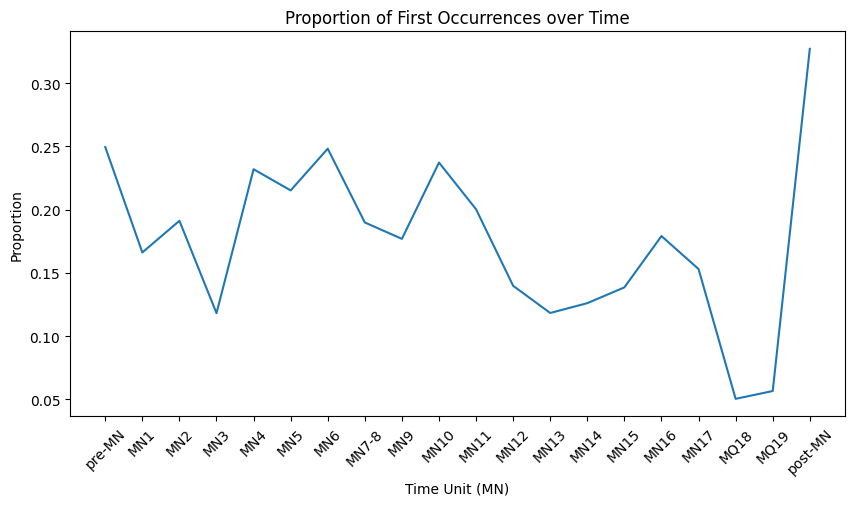

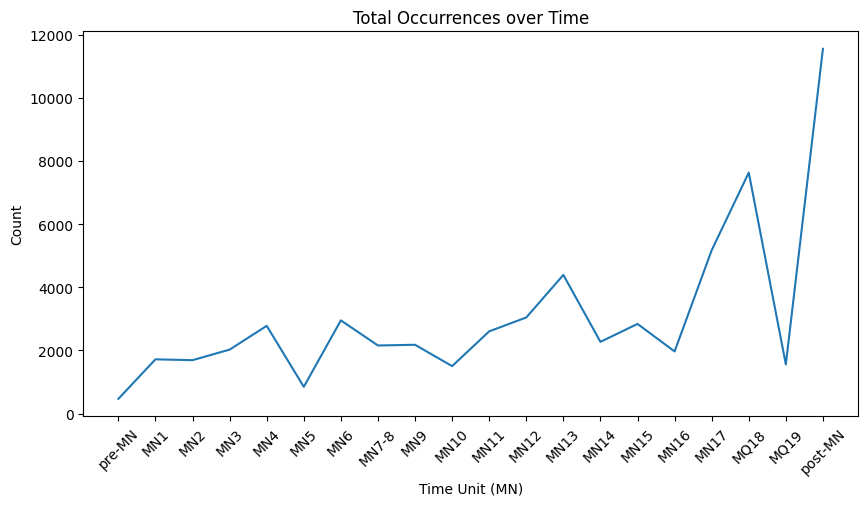

In [13]:
occurrences_by_species_mn = df.groupby(["SPECIES_ID", "MN"]).size().reset_index(name="count")
oldest_time_unit_df = occurrences_by_species_mn.groupby("SPECIES_ID")["MN"].apply(lambda x: sorted(x, key=lambda mn: MN_ORDERING.get(mn))[0]).reset_index(name="Oldest_MN")
first = oldest_time_unit_df.groupby("Oldest_MN")["SPECIES_ID"].count()
total = occurrences_by_species_mn.groupby("MN")["count"].sum()
merged = pd.merge(first, total, how="outer", left_index=True, right_index=True)
merged.fillna(0, inplace=True)
merged["first_occurrence_proportion"] = merged["SPECIES_ID"] / merged["count"]
merged = merged.rename(columns={"SPECIES_ID": "Species_Count_first", "count": "Total_Count", "first_occurrence_proportion": "Proportion_First_Occurrence"})


x = [mn for mn in MN_ORDERING.keys()]

proportion_first_occurrence = merged["Proportion_First_Occurrence"]
plt.figure(figsize=(10, 5))
plt.plot(x, proportion_first_occurrence)
plt.xlabel("Time Unit (MN)")
plt.ylabel("Proportion")
plt.title("Proportion of First Occurrences over Time")
plt.xticks(rotation=45)
plt.show()

total_occurrences = merged["Total_Count"]
plt.figure(figsize=(10, 5))
plt.plot(x, total_occurrences)
plt.xlabel("Time Unit (MN)")
plt.ylabel("Count")
plt.title("Total Occurrences over Time")
plt.xticks(rotation=45)
plt.show()


In [14]:
"""
Ex. 5 (a)
The section begins by merging multiple DataFrames based on specific columns. 
Then, the data is grouped by the locality number ('LIDNUM'), 
and the number of unique time units indicating first occurrences 
in each locality is calculated. Additionally, the total number of 
occurrences in each locality is determined. 
Finally, a new DataFrame is constructed.

Using LIDNUM to identify unique localities is better 
than using NAME because LIDNUM is a unique identifier,
whereas the NAME variable may contain duplicates or 
spelling variations. Using LIDNUM ensures that each 
locality is counted only once and that the data is consistent.
"""

"\nEx. 5 (a)\nThe section begins by merging multiple DataFrames based on specific columns. \nThen, the data is grouped by the locality number ('LIDNUM'), \nand the number of unique time units indicating first occurrences \nin each locality is calculated. Additionally, the total number of \noccurrences in each locality is determined. \nFinally, a new DataFrame is constructed.\n\nUsing LIDNUM to identify unique localities is better \nthan using NAME because LIDNUM is a unique identifier,\nwhereas the NAME variable may contain duplicates or \nspelling variations. Using LIDNUM ensures that each \nlocality is counted only once and that the data is consistent.\n"

In [15]:
merged_df = pd.merge(occurrences_by_species_mn, oldest_time_unit_df, on='SPECIES_ID')
merged_df = merged_df.rename(columns={"count": "Total_Count_MN"})
new_df = df[['LIDNUM', 'LAT', 'LONG','MN', 'SPECIES_ID']]
uusi = pd.merge(merged_df, new_df, on=['SPECIES_ID', 'MN'])
first_occurrences = uusi.groupby('LIDNUM')['Oldest_MN'].nunique()


all_occurrences =uusi.groupby('LIDNUM').size()

#proportion
proportion_first = first_occurrences / all_occurrences


locality_df = pd.DataFrame({
    'LIDNUM': first_occurrences.index,
    'Longitude': uusi.groupby('LIDNUM')['LONG'].first(),
    'Latitude': uusi.groupby('LIDNUM')['LAT'].first(),
    'Time_Unit': uusi.groupby('LIDNUM')['MN'].first(),
    'First_Occurrences': first_occurrences,
    'All_Occurrences': all_occurrences,
    'Proportion_First': proportion_first,
})


In [16]:
"""
Ex. 5 (b)

The code uses the geopandas library to read a world map shapefile 
and plot it using matplotlib. It then creates a scatter plot on 
top of the map, where the markers represent localities and their 
sizes are proportional to the number of occurrences. 
The resulting plot shows the distribution of these localities in space and time.
"""

'\nEx. 5 (b)\n\nThe code uses the geopandas library to read a world map shapefile \nand plot it using matplotlib. It then creates a scatter plot on \ntop of the map, where the markers represent localities and their \nsizes are proportional to the number of occurrences. \nThe resulting plot shows the distribution of these localities in space and time.\n'

C:\Users\D4RT5-REV\AppData\Local\Temp\ipykernel_12508\772492420.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


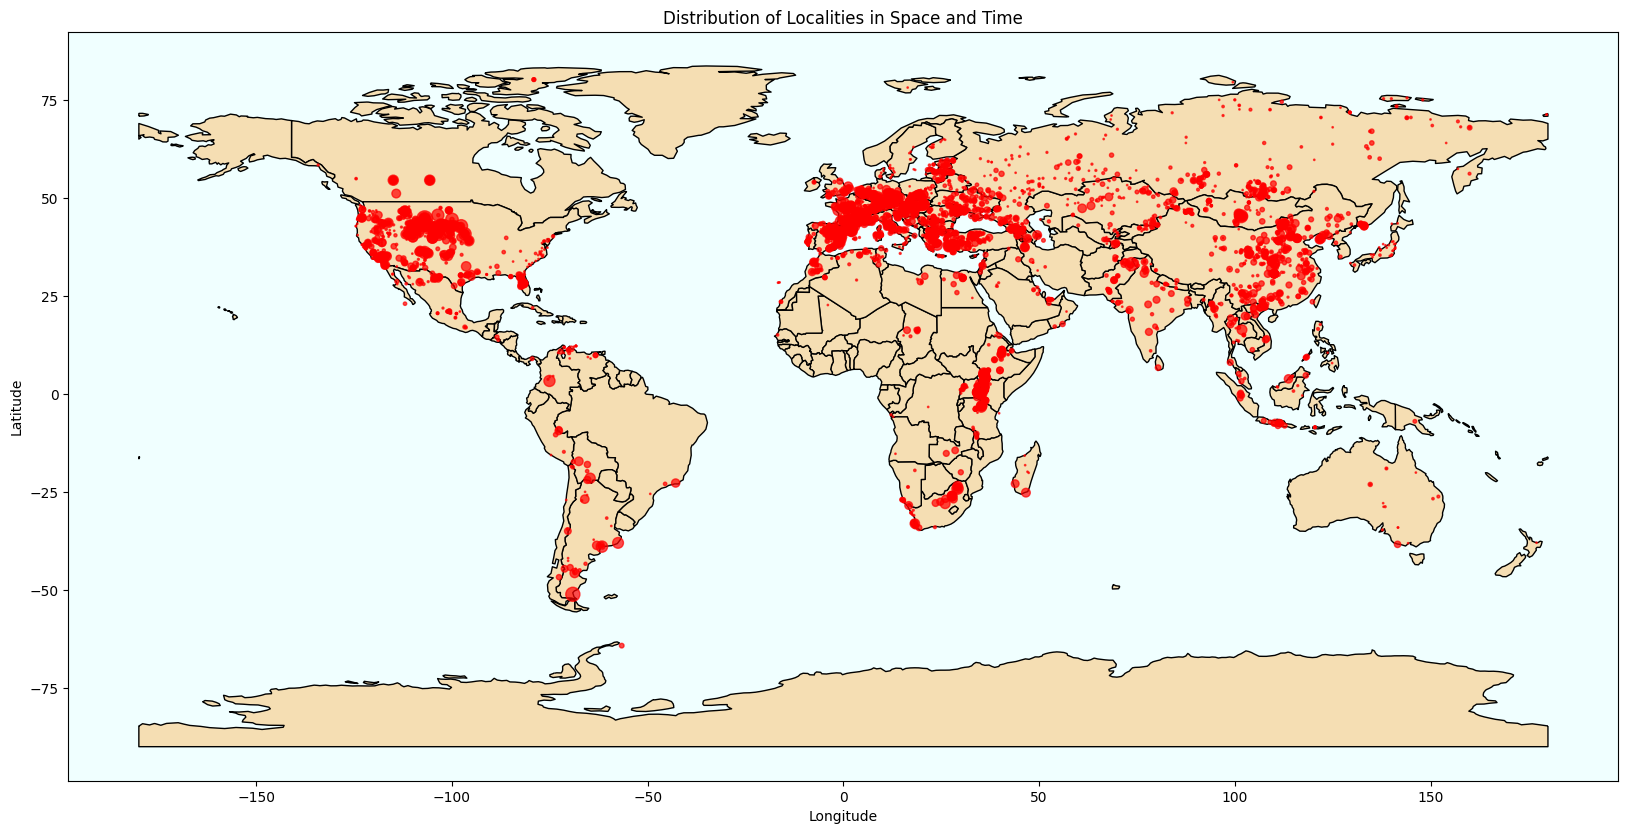

In [17]:
import geopandas as gpd



world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 10))
world.plot(ax=ax, color='wheat', edgecolor='black')
ax.set_facecolor('azure')


marker_sizes = locality_df['All_Occurrences']
ax.scatter(locality_df['Longitude'], locality_df['Latitude'], s=marker_sizes, alpha=0.7, c='red')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distribution of Localities in Space and Time')
plt.show()


In [18]:
"""
Ex. 5 (c)

From exercises 4 and 5, we can make several 
observations about sampling:

1. There are differences in sampling density over 
space and time. Some time units and locations have 
more occurrences and more species observed than others.

2. The proportion of first occurrences to all occurrences 
varies over time, with some time units having a higher 
proportion of first occurrences than others.

3. Africa, Asia, and Europe have different spatial coverage 
in terms of the number and distribution of localities. 
For example, Africa has more localities in the earlier 
time units than Asia and Europe.

4. The average number of occurrences per locality varies 
between the continents. For example, Africa generally has 
more occurrences per locality than Asia and Europe, 
especially in the earlier time units.

These observations suggest that there are biases in sampling 
effort and methods across time and space, which should be taken 
into account when interpreting the data and making 
inferences about species distributions and diversity.
"""

# %%
"""
Ex 6.
The code is iterating over each row in the locality_df DataFrame 
and calculating various occurrences based on geographical coordinates 
and time units. It creates a filtered DataFrame based on the specified 
range around the longitude and latitude values of each row, and then 
calculates the total and first occurrences within that range. 
Additionally, it calculates the total occurrences in the preceding 
time unit within the same geographical range. 
The results are then assigned to corresponding columns in the locality_df DataFrame.
"""

lon_range = 10
lat_range = 10


locality_df['Total_Occurrences_10x10'] = 0
locality_df['First_Occurrences_10x10'] = 0
locality_df['Total_Occurrences_Preceding'] = 0


for index, row in locality_df.iterrows():
    lon = row['Longitude']
    lat = row['Latitude']
    time_unit = row['Time_Unit']
    time_unit_index = MN_ORDERING[time_unit]
    lon_min = lon - lon_range / 2
    lon_max = lon + lon_range / 2
    lat_min = lat - lat_range / 2
    lat_max = lat + lat_range / 2

    filtered_df = locality_df[
        (locality_df['Longitude'] >= lon_min) &
        (locality_df['Longitude'] <= lon_max) &
        (locality_df['Latitude'] >= lat_min) &
        (locality_df['Latitude'] <= lat_max)
    ]
    
    total_occurrences_10x10 = filtered_df['All_Occurrences'].sum()
    first_occurrences_10x10 = filtered_df['First_Occurrences'].sum()
    

    total_occurrences_preceding = locality_df[
        (locality_df['Longitude'] >= lon_min) &
        (locality_df['Longitude'] <= lon_max) &
        (locality_df['Latitude'] >= lat_min) &
        (locality_df['Latitude'] <= lat_max) &
        (locality_df['Time_Unit'] == 'MN{}'.format(time_unit_index - 1))
    ]['All_Occurrences'].sum()


    locality_df.at[index, 'Total_Occurrences_10x10'] = total_occurrences_10x10
    locality_df.at[index, 'First_Occurrences_10x10'] = first_occurrences_10x10
    locality_df.at[index, 'Total_Occurrences_Preceding'] = total_occurrences_preceding






Optimization terminated successfully.
         Current function value: 0.544419
         Iterations 5


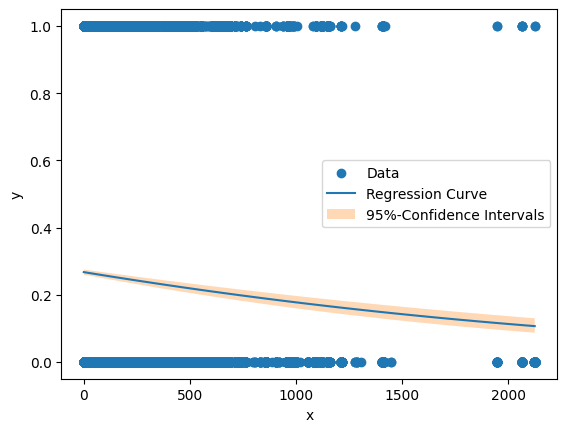

In [19]:

# %%
"""
Ex 7. (a),(b),(c)
This code performs logistic regression analysis on a dataset. 
It selects specific columns from a DataFrame and prepares the 
data for regression. It then fits a logistic regression model 
using the selected variables and displays the model summary.
The code also calculates the coefficients and confidence intervals.
Finally, it generates a plot with the data points, 
the logistic regression curve, and the 95% confidence intervals.
"""
import numpy as np
from statsmodels import api as sm

occurrences_preceding = locality_df[['LIDNUM', 'Total_Occurrences_Preceding']].set_index('LIDNUM')
#oldest_time_unit_df
df_subset =  df[
    (df['LONG'] > -25) &
    (df['LONG'] < 40) &
    (df['LAT'] > 35) &
    (df['MN'].isin(['MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19']))
]

df_subset = df_subset[['LIDNUM', 'SPECIES_ID', 'MN']].set_index('SPECIES_ID')

oldest = oldest_time_unit_df.set_index('SPECIES_ID')


merge_oldest = df_subset.join(oldest, how='left', rsuffix='oldest').reset_index().set_index('LIDNUM')

merge_preceding = merge_oldest.join(occurrences_preceding, how='left', rsuffix='preceding').reset_index()

merge_preceding['is_first_occurrence'] = (merge_preceding['MN'] == merge_preceding['Oldest_MN']).astype('int')


regression_df = merge_preceding[['Total_Occurrences_Preceding', 'is_first_occurrence']].copy()
reg_dat = np.array(regression_df)
X = reg_dat[:,0]
X = sm.add_constant(X)
y = reg_dat[:,1]
model = sm.Logit(y, X)
result = model.fit()
coefficients = result.params
confidence95 = result.conf_int(alpha=0.05)


def logit_curve(x, coefficients):
    return 1 / (1 + np.exp(-coefficients[0] - coefficients[1] * x))


x_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
y_values = logit_curve(x_values, coefficients)

#confidence intervals
upper_ci = logit_curve(x_values, confidence95[:,0])
lower_ci = logit_curve(x_values, confidence95[:,1])


plt.scatter(X[:, 1], y, label='Data')
plt.plot(x_values, y_values, label='Regression Curve')
plt.fill_between(x_values, lower_ci, upper_ci, alpha=0.3, label='95%-Confidence Intervals')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()




In [20]:
# %%
"""
Ex 8.
Uses the function logit_curve created for ex. 7(a), 
so we can calculate the expected probability. 
"""

locality_df['logistic_probability_first'] = logit_curve(locality_df['Total_Occurrences_Preceding'], coefficients)

# %%
"""
Ex. 9.
The code uses the binom function from the scipy.stats module 
to calculate the probability of observing at least a certain 
number of first occurrences in a given dataset. It calculates 
the probability based on the total occurrences, the number of 
first occurrences, and the probability of any occurrence being 
a first occurrence. It then identifies the rows in the dataset 
where the calculated probability is less than or equal to 0.05,
 indicating a higher occurrence of first occurrences than expected.
"""

from scipy.stats import binom

n = locality_df['Total_Occurrences_10x10']
k = locality_df['First_Occurrences_10x10']
p = locality_df['logistic_probability_first']

locality_df['binom_probability'] = 1 - binom.cdf(k, n, p)

more_than_expected = locality_df[locality_df['binom_probability'] <= 0.05]




C:\Users\D4RT5-REV\AppData\Local\Temp\ipykernel_12508\2740104095.py:41: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  europe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


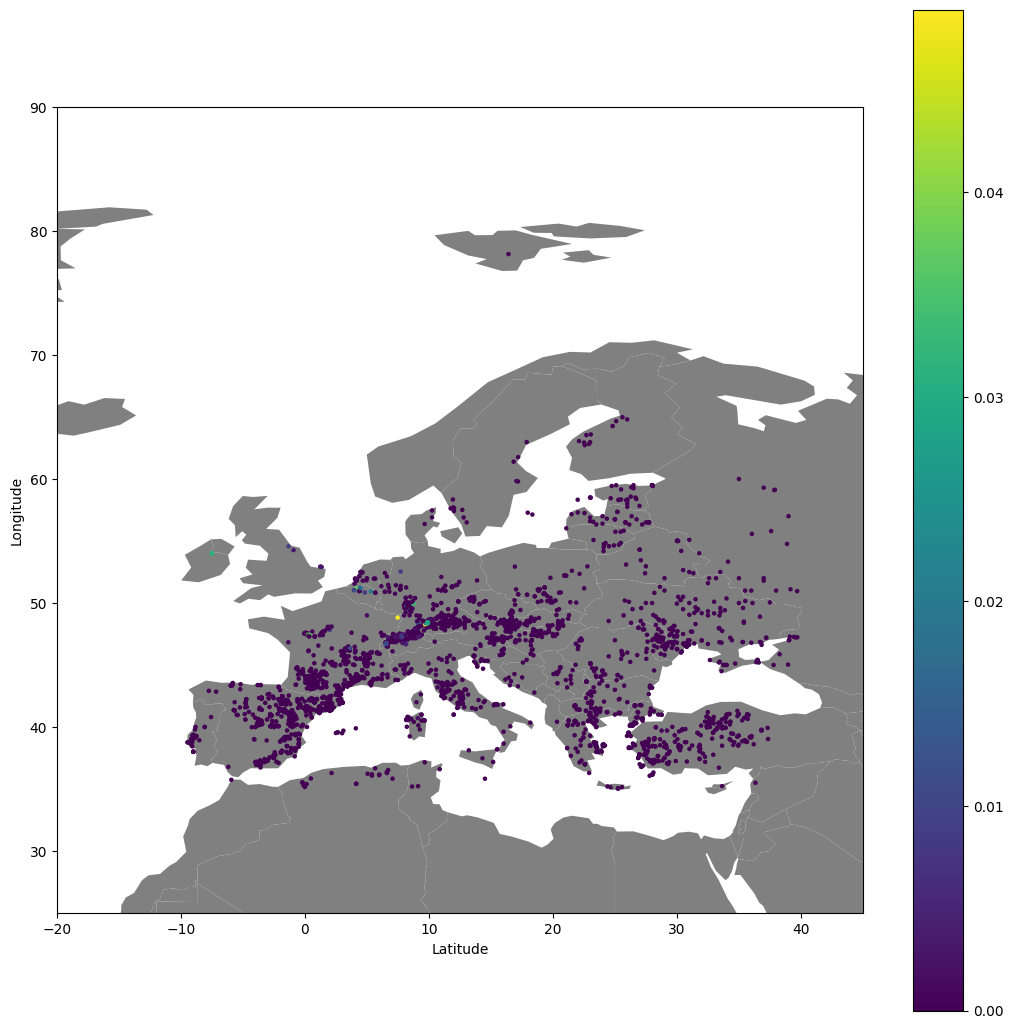

In [21]:
# %%
"""
Ex. 10.
It selects significant localities from the dataframe locality_df 
based on a condition that their 'binom_probability' column values are less than 0.05.
It creates a GeoDataFrame (gdf) by assigning the latitude and 
longitude values from the dataframe to a geometry column.
It filters the gdf based on longitude and latitude conditions, 
selects the significant localities again, and plots them on a map of 
Europe (since all datapoints are in europe, and are easier to see) 
using the 'binom_probability' values to determine the color intensity of the markers.

The values observed on the map indicate that there is a few localitites with a p-value 
larger than 0.05 and these localities do not show a strong evidence of an unexpectedly 
high number of first occurrences, and their patterns are more likely to be influenced 
by random chance or natural variation. We also see that there is a large number of localities
where the p value is under 0.05, which indicates that there is strong evidence to reject the 
null hypothesis, suggesting that the observed number of first occurrences is significantly 
higher than what would be expected by chance alone. In other words, it is less likely to be a random occurrence.
"""

significant_localities = locality_df[locality_df['binom_probability'] < 0.05]



geometry = gpd.points_from_xy(locality_df['Longitude'], locality_df['Latitude'])
gdf = gpd.GeoDataFrame(locality_df, geometry=geometry)

filtered_localities = gdf[(gdf['Longitude'] > -25) & (gdf['Longitude'] < 40) & (gdf['Latitude'] > 35)]


significant_localities = filtered_localities[filtered_localities['binom_probability'] < 0.05]
europe = (-20, 25, 45, 90) 


fig, ax = plt.subplots(figsize=(13, 13))
ax.set_xlim(europe[0], europe[2])
ax.set_ylim(europe[1], europe[3])


europe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe.plot(ax=ax, color='grey')
significant_localities.plot(ax=ax, column='binom_probability', cmap='viridis', markersize=5, legend=True)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()